In [1]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from datasets import load_dataset
import torch

In [2]:
processor = Wav2Vec2Processor.from_pretrained("kresnik/wav2vec2-large-xlsr-korean")

model = Wav2Vec2ForCTC.from_pretrained("kresnik/wav2vec2-large-xlsr-korean")

ds = load_dataset("bingsu/zeroth-korean")

In [3]:
test_ds = ds['test']

In [4]:
def map_to_pred(batch):
    speech_samples = [item['array'] for item in batch['audio']]
    inputs = processor(speech_samples, sampling_rate=16000, return_tensors="pt", padding="longest")
    input_values = inputs.input_values
    #attention_mask = inputs.attention_mask.to("cuda")
    
    with torch.no_grad():
        #logits = model(input_values, attention_mask=attention_mask).logits
        logits = model(input_values).logits
    
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)
    batch["transcription"] = transcription
    return batch

result = test_ds.map(map_to_pred, batched=True, batch_size=16)

Map:   0%|          | 0/457 [00:00<?, ? examples/s]

2024-10-08 16:03:31.875456: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-08 16:03:31.881709: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-08 16:03:31.927050: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-08 16:03:31.970260: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 16:03:32.030285: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [6]:
import evaluate as eval
wer = eval.load("wer")
cer = eval.load("cer")
result_wer = wer.compute(references=result["text"], predictions=result["transcription"])
result_cer = cer.compute(references=result["text"], predictions=result["transcription"])
print(f'WER:{result_wer*100:.2f}%')
print(f'CER:{result_cer*100:.2f}%')

ImportError: To be able to use evaluate-metric/wer, you need to install the following dependencies['jiwer'] using 'pip install jiwer' for instance'

In [8]:
train_ds = ds['train']
train_ds

<unk>


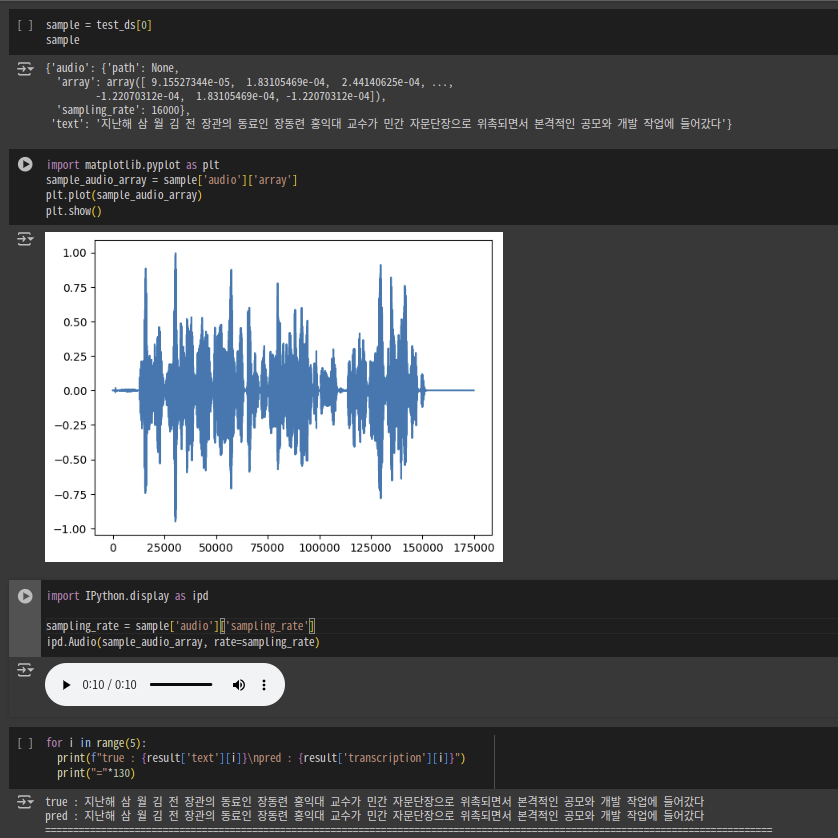